# CS 178 - Homework 2
### Aditya Iyer - 24377286

In [1]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# for testing and repeated use
def print_array(arr): 
    print(arr)
    print("\n")

## Problem 1
### 1.1

In [3]:
data = np.genfromtxt("data/curve80.txt",delimiter=None)
X = data[:,0] #feature X
X = np.atleast_2d(X).T # code expects shape (M,N) so make sure it's 2-dimensional
Y = data[:,1] #target Y
Xtr,Xte,Ytr,Yte = ml.splitData(X,Y,0.75) # split data set 75/25
print("Xtr shape: {}".format(Xtr.shape))
print("Xte shape: {}".format(Xte.shape))
print("Ytr shape: {}".format(Ytr.shape))
print("Yte shape: {}".format(Yte.shape))
    

Xtr shape: (60, 1)
Xte shape: (20, 1)
Ytr shape: (60,)
Yte shape: (20,)


### 1.2

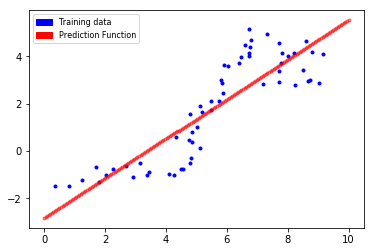

Linear regression coefficients: [-2.82765049  0.83606916]
The regression coefficients: y-intercept = -2.82.. and slope of 0.836.. match the plot


MSE for the training data: 1.127711955609391

MSE for the test data: 2.242349203010125


In [4]:
lr = ml.linear.linearRegress( Xtr, Ytr ) # create and train model
xs = np.linspace(0,10,200) # densely sample possible x-values
xs = xs[:,np.newaxis] # force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict( xs ) # make predictions at x
error_sum = 0

## 1.2 a
for i in range(len(Xtr)):
    plt.plot(Xtr[i][0],Ytr[i],"b.")
for i in range(len(xs)):
    plt.plot(xs[i][0],ys[i][0],"r.",alpha=0.45)
# for creating a legend
blue_patch = mpatches.Patch(color='blue', label='Training data')
red_patch = mpatches.Patch(color='red', label='Prediction Function')
plt.legend(handles = [blue_patch,red_patch], ncol=1,fontsize=8)
plt.show()

## 1.2 b
print("Linear regression coefficients: {}".format(lr.theta[0]))
print("The regression coefficients: y-intercept = -2.82.. and slope of 0.836.. match the plot\n")

## 1.2 c
for i in range(len(Xtr)):
    Yhattr = Xtr[i][0] * lr.theta[0][1] + lr.theta[0][0]
    error = Ytr[i] - Yhattr
    error *= error
    error_sum += error
error_sum /= len(Xtr)
print("\nMSE for the training data: {}".format(error_sum))

error_sum = 0
for i in range(len(Xte)):
    Yhatte = Xte[i][0] * lr.theta[0][1] + lr.theta[0][0]
    error = Yte[i] - Yhatte
    error *= error
    error_sum += error
error_sum /= len(Xte)
print("\nMSE for the test data: {}".format(error_sum))


### 1.3

In [5]:
def phi(X,degree,params):
    return ml.transforms.rescale( ml.transforms.fpoly(X, degree,False), params)[0]
    # the parameters "degree" and "params" are memorized at the function definition

d = [1,3,5,7,10,18]
lr_arr = [0,0,0,0,0,0]
def poly_function(degree):
    # Create polynomial features up to "degree"; don't create constant feature
    # (the linear regression learner will add the constant feature automatically)
    XtrP = ml.transforms.fpoly(Xtr, degree, bias=False)

    # Rescale the data matrix so that the features have similar ranges / variance
    XtrP,params = ml.transforms.rescale(XtrP)
    # "params" returns the transformation parameters (shift & scale)

    # Then we can train the model on the scaled feature matrix:
    lr = ml.linear.linearRegress( XtrP, Ytr ) # create and train model
    xs = np.linspace(0,10,200) # densely sample possible x-values
    xs = xs[:,np.newaxis] # force "xs" to be an Mx1 matrix (expected by our code)
    ys = lr.predict(phi(xs,degree,params))

    # Now, apply the same polynomial expansion & scaling transformation to Xtest:
    XteP,_ = ml.transforms.rescale( ml.transforms.fpoly(Xte,degree,False), params)
    return (xs,ys,lr)

### 1.3 a

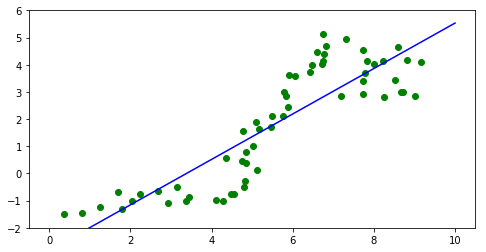

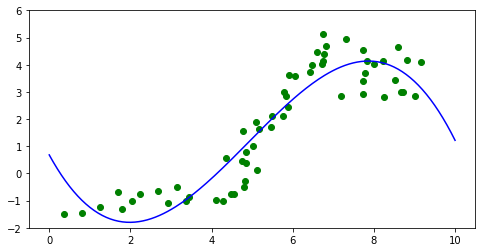

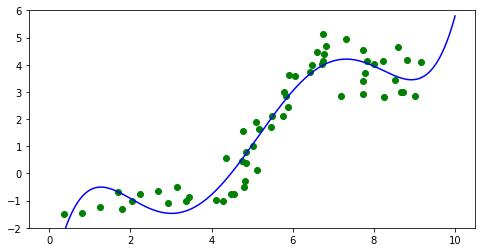

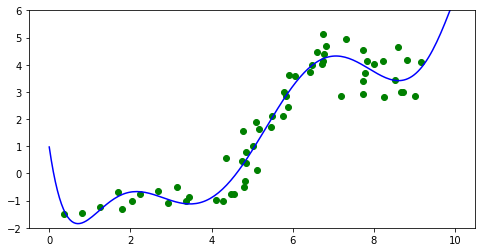

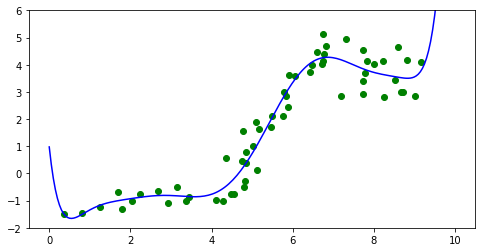

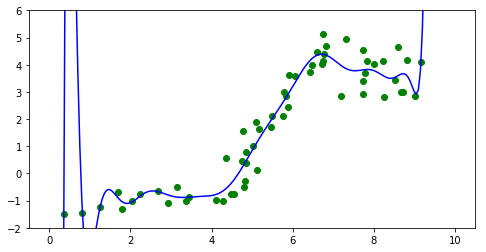

In [6]:
for i in range(len(d)):
    xs,ys,lr_arr[i] = poly_function(d[i])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4)) 
    ax.scatter(Xtr,Ytr,color="green")
    ax.plot(xs,ys,color="blue") # Plot for each polynomial degree
    ax.set_ylim(-2, 6) # Set the minimum and maximum limits
plt.show()

### 1.3 b

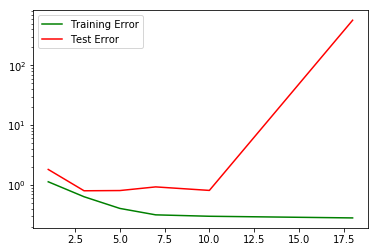

In [7]:
err_train = [0,0,0,0,0,0]
err_test = [0,0,0,0,0,0]

def poly_mse(degree,index,lr):
    
    XtrP = ml.transforms.fpoly(Xtr, degree, bias=False) 
    XtrP,params = ml.transforms.rescale(XtrP)
    
    XteP = ml.transforms.fpoly(Xte, degree, bias=False) 
    XteP,params = ml.transforms.rescale(XteP)
    
    err_train[index] = lr.mse(XtrP,Ytr)
    err_test[index] = lr.mse(XteP,Yte)
    
for i in range(len(d)):
    poly_mse(d[i],i,lr_arr[i])

plt.semilogy(d,err_train,color="green",label="Training Error")
plt.semilogy(d,err_test,color="red",label="Test Error")
plt.legend()
plt.show()
#print(err_test)

### 1.3c
I recommend the degree of 10 as this produces the lowest Test and Training error. Degrees (10,18] represent overfitting while equivalent Test errors at lower degrees yield higher Training errors.

## Problem 2

## 2.1

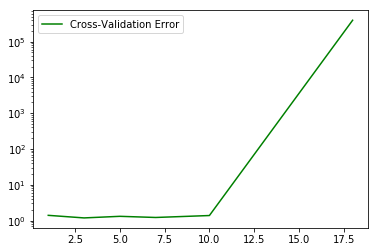

In [8]:
mean_arr = [0,0,0,0,0,0]

fold_arr = [2,3,4,5,6,10,12,15]
fold_mean_arr = [0,0,0,0,0,0,0,0]

def fold_mse(degree,nFolds):
    J = [0 for i in range(nFolds)]
    for iFold in range(nFolds):
        Xti,Xvi,Yti,Yvi = ml.crossValidate(Xtr,Ytr,nFolds,iFold) # use ith block as validation
        
        XtiP = ml.transforms.fpoly(Xti, degree, bias=False) 
        XtiP,params = ml.transforms.rescale(XtiP)
        
        XviP = ml.transforms.fpoly(Xvi, degree, bias=False) 
        XviP,params = ml.transforms.rescale(XviP)
        
        learner = ml.linear.linearRegress(XtiP,Yti)
        J[iFold] = learner.mse(XviP,Yvi)
        # the overall estimated validation error is the average of the error on each fold
    return np.mean(J)

for i in range(len(d)):
    mean_arr[i] = fold_mse(d[i],fold_arr[3])
plt.semilogy(d,mean_arr,color="green",label="Cross-Validation Error")
plt.legend()
plt.show()
#print(mean_arr)

### 2.2
The 5-fold MSE estimates are similar in value (close to 1.3) until degree = 18, where overfitting occurs. The 5-fold Mse estimates are all greater than the estimates from problem 1.

### 2.3
I would recommend a polynomial degree of 10 as it yields the lowest MSE estimate

### 2.4

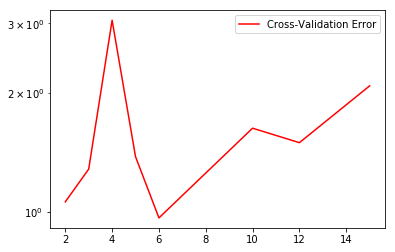

In [9]:
degree = 10
for i in range(len(fold_arr)):
    fold_mean_arr[i] = fold_mse(degree,fold_arr[i])
    
plt.semilogy(fold_arr,fold_mean_arr,color="red",label="Cross-Validation Error")
plt.legend()
plt.show()

There is a large spike at nFolds = 4 and then after nFolds = 6, the estimated error increases as the number of Folds increases. This might be due to the number of subdivisions of training and validation data and the number of errors to average over. The larger number of splits there are, the likelihood of having "bad" data to train on when split over a random data set.

## Statement of Collaboration
I discussed how to solve certain problems (regarding MSE) and encapsulating code segments into function with my partner Jeffrey Araki. Some code is taken from the homework assignment and the discussion (formatting/displaying plots).